Using cache found in /Users/pbenschop1/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-10-4 Python-3.9.18 torch-2.4.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


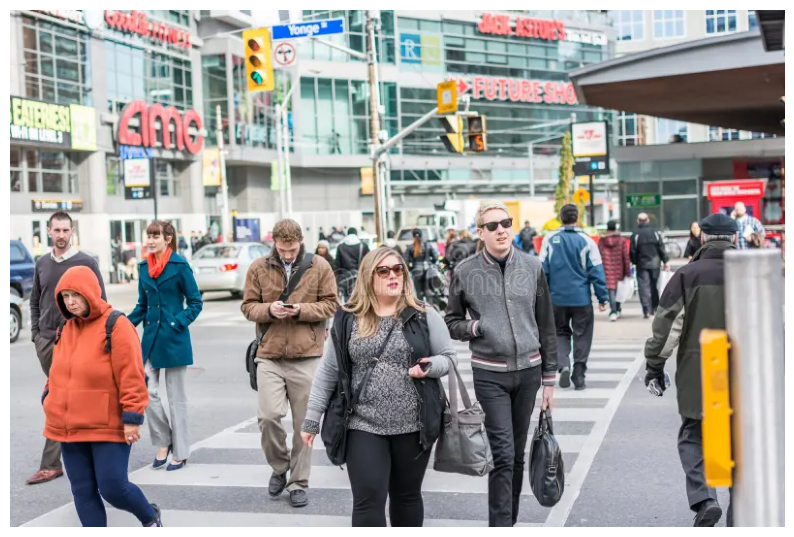

In [22]:
%matplotlib inline

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from transformers import CLIPProcessor, CLIPModel
from deepface import DeepFace


#################### INPUT ####################
image_path = r"extra/Street_sample.png"  # Replace with the path to your image

###############################################

# Load CLIP model and processor
ClipModel = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

# ClipModel = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

# Load YOLOv5 model from torchhub for person detection
YOLOModel = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

import time
start_time = time.time()

# Load the image using OpenCV
img = cv2.imread(image_path)

# Convert image to RGB (as OpenCV loads in BGR)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()



1/1 [==============================] - 0s 11ms/step


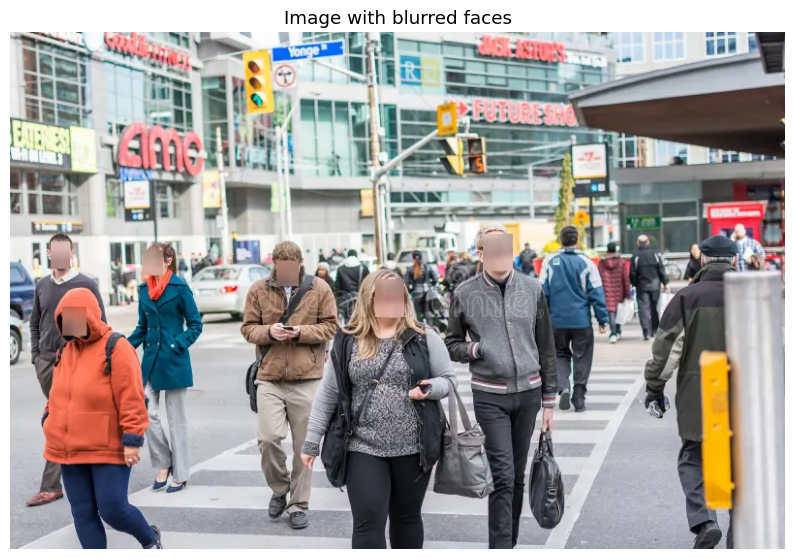

In [23]:
def resize_image(img, size=(200, 500), adjust_opencv=False):
    # Get image from PIL Image
    img = Image.fromarray(img)
    # Resize the image
    img = img.resize(size)
    # Sharpen image
    # img = img.filter(ImageFilter.SHARPEN)

    if adjust_opencv:  
        # Convert back to OpenCV format
        img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    return img

with torch.no_grad():

    face_detect = DeepFace.extract_faces(np.array(img_rgb), detector_backend='mtcnn', enforce_detection=False)

    for detected_face in face_detect:
        if detected_face['confidence'] < 0.8:
            continue
        facial_area = detected_face['facial_area']

        # Extract facial area coordinates
        x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']
        # Blur the facial area
        roi = img[y:y+h, x:x+w]
        roi = cv2.GaussianBlur(roi, (23, 23), 30)
        img[y:y+roi.shape[0], x:x+roi.shape[1]] = roi

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.title("Image with blurred faces")
    plt.axis('off')
    plt.show()


Probabilities:  tensor([[26.94660],
        [25.81040],
        [24.53923],
        [25.30189],
        [24.08200],
        [24.44651],
        [22.03990],
        [24.92041],
        [25.63005],
        [22.92006],
        [24.17957],
        [22.08721],
        [21.40792],
        [22.32442],
        [22.77389]])
Scores after normalization: 
[[        100]
 [      95.78]
 [      91.07]
 [       93.9]
 [      89.37]
 [      90.72]
 [      81.79]
 [      92.48]
 [      95.11]
 [      85.06]
 [      89.73]
 [      81.97]
 [      79.45]
 [      82.85]
 [      84.51]]
Person ID: 0, Average Match: 100.00%, scores: [        100]
Person ID: 1, Average Match: 95.78%, scores: [      95.78]
Person ID: 2, Average Match: 91.07%, scores: [      91.07]
Person ID: 4, Average Match: 93.90%, scores: [       93.9]
Person ID: 5, Average Match: 89.37%, scores: [      89.37]
Person ID: 7, Average Match: 90.72%, scores: [      90.72]
Person ID: 8, Average Match: 81.79%, scores: [      81.79]
Person ID: 9, 

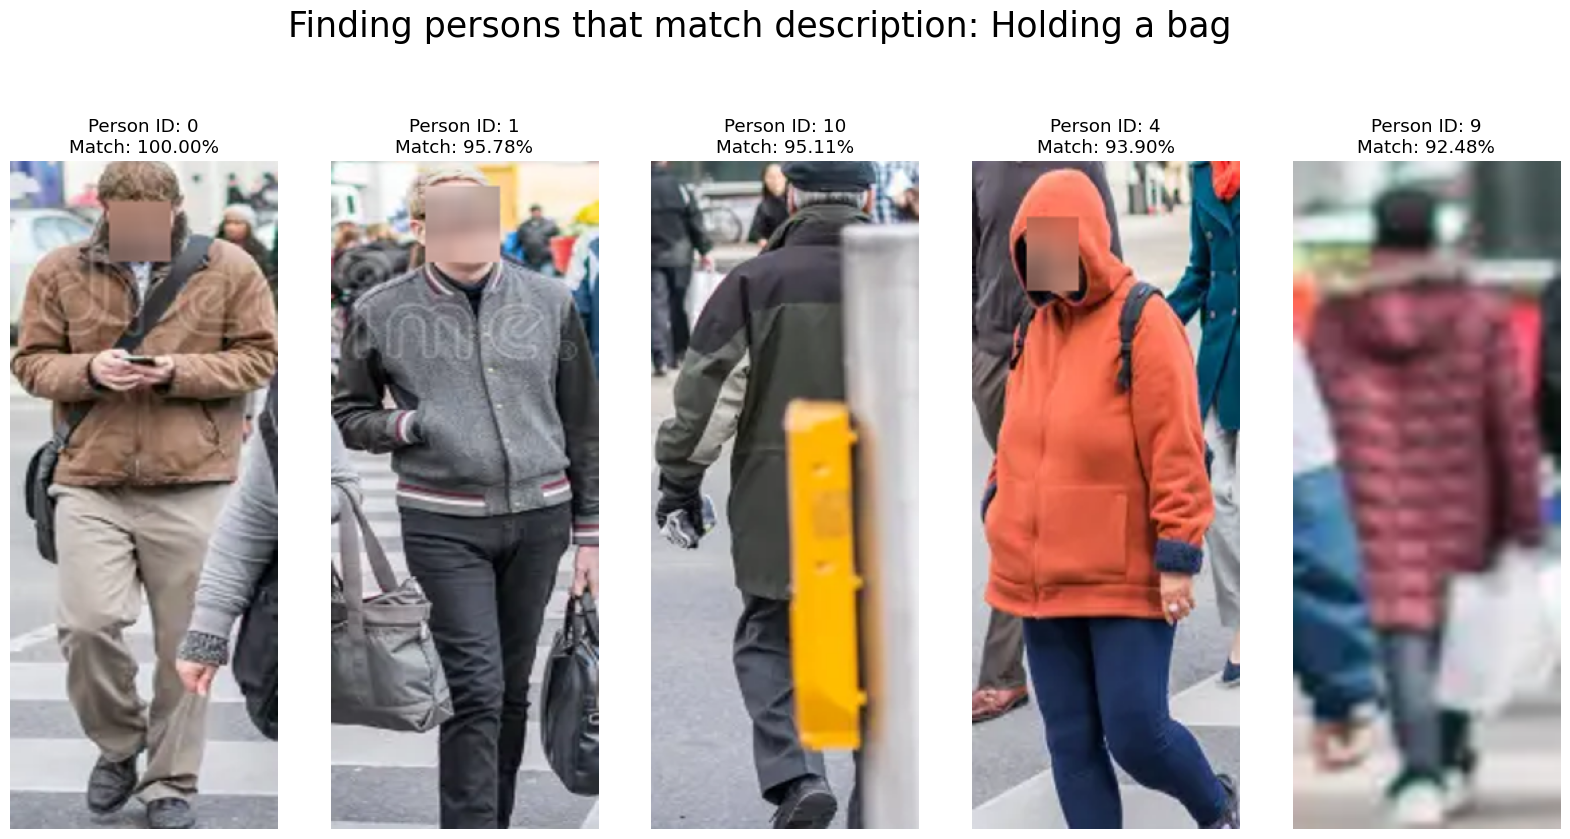

In [27]:
##################### INPUT #####################
caption = [
    "Holding a bag",
]


with torch.no_grad():  
  # Detect persons using YOLOv5
    results = YOLOModel(img_rgb)

    # Step 2: Detect Persons and Get Similarity Scores
    detected_persons = []
    for i, (boxes, scores, classes) in enumerate(zip(results.xyxy[0], results.pred[0][:, 4], results.pred[0][:, 5])):
        if classes == 0:  # Person class
            x1, y1, x2, y2 = map(int, boxes[:4].tolist())  # Bounding box coordinates
            # Crop the person region
            cropped_person = img_rgb[y1:y2, x1:x2]

            # Resize the cropped person image
            cropped_person = resize_image(cropped_person)
            
            detected_persons.append({
                'person_id': i,
                'box': (x1, y1, x2, y2),
                'cropped_person': cropped_person,
            })

    # Step 3: Preprocess the Image and Captions
    inputs = processor(text=caption, images=[person['cropped_person'] for person in detected_persons], return_tensors="pt", padding=True)

    # Get the outputs from CLIP
    outputs = ClipModel(**inputs)

    # Calculate similarity scores
    logits_per_image = outputs.logits_per_image  # Image-text similarity score
    # probs = logits_per_image.softmax(dim=1)  # Apply softmax to get probabilities
    probs = logits_per_image
    print("Probabilities: ", probs)
    scores = probs

    max_per_column = scores.max(dim=0, keepdim=True)[0]
    normalized_scores = scores / max_per_column  # Normalize each column
    scores = normalized_scores * 100  # Scale the highest value in each column to 100%

    # Convert scores to numpy array and format them
    scores_np = scores.cpu().numpy()
    formatted_scores = np.round(scores_np, 2)

    print("Scores after normalization: ")
    print(formatted_scores)

    # Add normalized scores back to the persons and calculate average match
    for i, person in enumerate(detected_persons):
        detected_persons[i]['normalized_scores'] = scores[i]
        detected_persons[i]['avg_score'] = scores[i].mean().item()  # Average similarity score

        print(f"Person ID: {person['person_id']}, Average Match: {person['avg_score']:.2f}%, scores: {formatted_scores[i]}")

    # Sort persons by average similarity score in descending order
    detected_persons = sorted(detected_persons, key=lambda x: x['avg_score'], reverse=True)

    final_time = time.time() - start_time
    print(f"Time taken: {final_time:.2f} seconds")


    ###############################################


    max_images = 5
    found_persons = []

    # Step 4: Display Persons with Captions Sorted by Similarity
    for i, person in enumerate(detected_persons):
        # Calculate average match percentage
        match_percentage = person['avg_score']

        found_persons.append(person)

        if i == max_images - 1:
            break



# Display the images with captions
fig, axes = plt.subplots(1, max_images, figsize=(20, 10))
for i, person in enumerate(found_persons):
    ax = axes[i]
    ax.imshow(person['cropped_person'])
    ax.axis('off')
    ax.set_title(f"Person ID: {person['person_id']}\nMatch: {person['avg_score']:.2f}%")

plt.suptitle("Finding persons that match description: {}".format(caption[0]), fontsize=25)
# Flush matplotlib plots to display the images
plt.show()


(306, 500, 3)


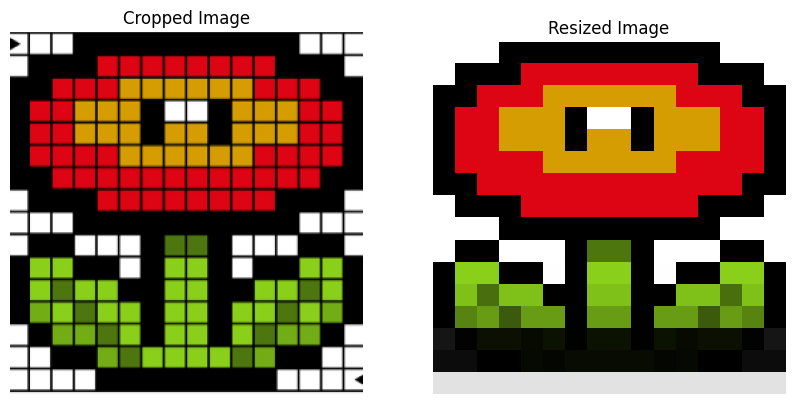

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from PIL import Image


# Load the image
img_path = "extra/flower.png"
img = Image.open(img_path)

# Convert the image to RGB (in case it's not)
img_rgb = img.convert('RGB')

# Convert image to numpy array
pixel_array = np.array(img_rgb)

# Display the shape of the pixel array to understand dimensions
pixel_array.shape
print(pixel_array.shape)

cropped_img = img_rgb.crop((105, 20, 370, 300))

# Resize the cropped image to 16x16
flower_img = cropped_img.resize((16, 16), Image.NEAREST)

# Convert the resized image to a numpy array
flower_pixel_array = np.array(flower_img)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(cropped_img)
axs[0].set_title("Cropped Image")
axs[0].axis('off')
axs[1].imshow(flower_img)
axs[1].set_title("Resized Image")
axs[1].axis('off')

plt.show()

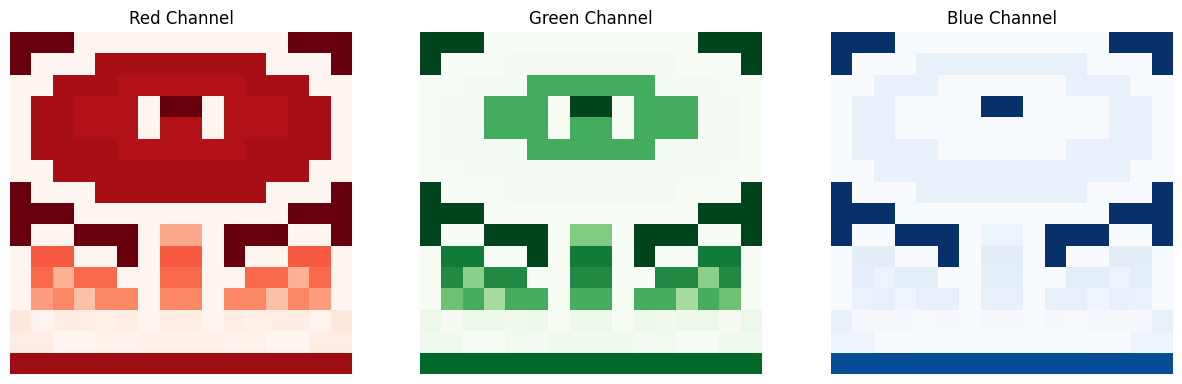

In [2]:
# Extract individual channels from the flower image
red_channel = flower_pixel_array[:, :, 0]
green_channel = flower_pixel_array[:, :, 1]
blue_channel = flower_pixel_array[:, :, 2]

# Create images for each channel
red_image = Image.fromarray(red_channel, mode='L')
green_image = Image.fromarray(green_channel, mode='L')
blue_image = Image.fromarray(blue_channel, mode='L')

# Display the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(red_image, cmap='Reds')
axs[0].set_title("Red Channel")
axs[0].axis('off')

axs[1].imshow(green_image, cmap='Greens')
axs[1].set_title("Green Channel")
axs[1].axis('off')

axs[2].imshow(blue_image, cmap='Blues')
axs[2].set_title("Blue Channel")
axs[2].axis('off')

plt.show()

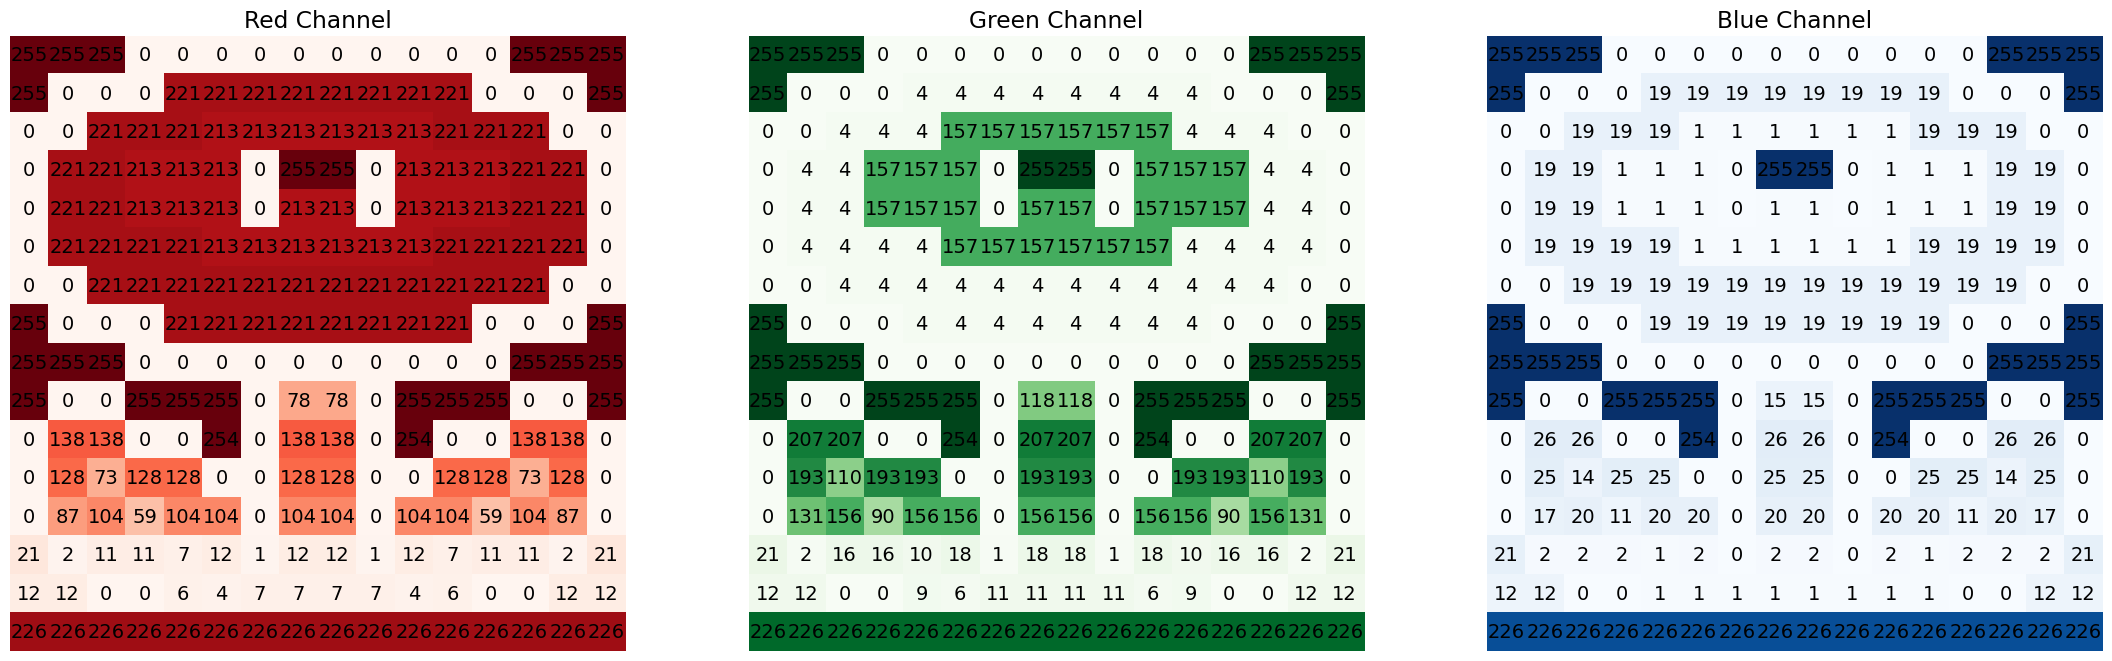

In [3]:
# Display the images with pixel values
fig, axs = plt.subplots(1, 3, figsize=(27, 9))

plt.rcParams.update({'font.size': 14})

# Red channel
axs[0].imshow(red_image, cmap='Reds')
axs[0].set_title("Red Channel")
axs[0].axis('off')
for i in range(red_channel.shape[0]):
    for j in range(red_channel.shape[1]):
        axs[0].text(j, i, red_channel[i, j], ha='center', va='center', color='black')

# Green channel
axs[1].imshow(green_image, cmap='Greens')
axs[1].set_title("Green Channel")
axs[1].axis('off')
for i in range(green_channel.shape[0]):
    for j in range(green_channel.shape[1]):
        axs[1].text(j, i, green_channel[i, j], ha='center', va='center', color='black')

# Blue channel
axs[2].imshow(blue_image, cmap='Blues')
axs[2].set_title("Blue Channel")
axs[2].axis('off')
for i in range(blue_channel.shape[0]):
    for j in range(blue_channel.shape[1]):
        axs[2].text(j, i, blue_channel[i, j], ha='center', va='center', color='black')

plt.show()

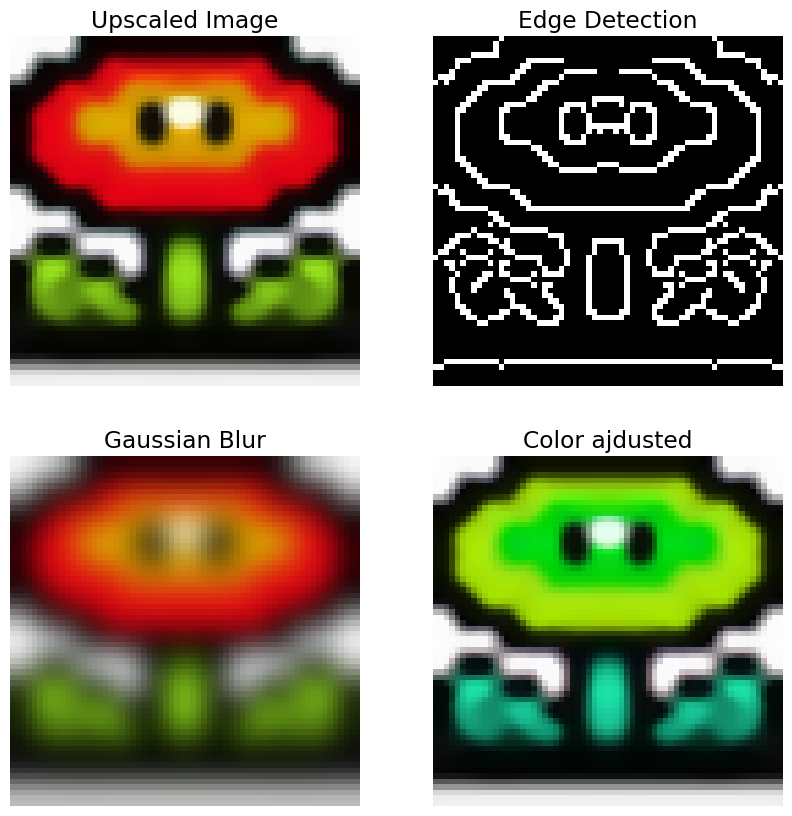

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Convert the flower image to grayscale
# Upscale the image
flower_upscaled = cv2.resize(np.array(flower_img), (64, 64), interpolation=cv2.INTER_CUBIC)
flower_upscaled = cv2.bilateralFilter(flower_upscaled, 9, 75, 75)

# Convert the upscaled image to HSV
flower_hsv = cv2.cvtColor(flower_upscaled, cv2.COLOR_RGB2HSV)

# Apply a color shift to the hue channel
flower_hsv[:, :, 0] = (flower_hsv[:, :, 0] + 40) % 180

flower_filtered = cv2.cvtColor(flower_hsv, cv2.COLOR_HSV2RGB)

# Edge Detection
flower_gray = cv2.cvtColor(flower_upscaled, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(flower_gray, 100, 200)

# Apply Gaussian Blur
blurred = cv2.GaussianBlur(flower_upscaled, (15, 15), 0)

# Display the results
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Original Image
axs[0, 0].imshow(flower_upscaled)
axs[0, 0].set_title("Upscaled Image")
axs[0, 0].axis('off')

# Edge Detection
axs[0, 1].imshow(edges, cmap='gray')
axs[0, 1].set_title("Edge Detection")
axs[0, 1].axis('off')

# Blurred Image
axs[1, 0].imshow(blurred)
axs[1, 0].set_title("Gaussian Blur")
axs[1, 0].axis('off')

# Hue Adjusted Image
axs[1, 1].imshow(flower_filtered)
axs[1, 1].set_title("Color ajdusted")
axs[1, 1].axis('off')

# Display the images
plt.show()